<a href="https://colab.research.google.com/github/AlipourIm/ML_cysec_WiSe_25-26/blob/main/getting_started_with_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started 3: Classic Machine Learning for Cybersecurity

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Resolved&color=green)


**Open notebook on:**
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/clandolt/mlcysec_notebooks/blob/main/source/tutorial_notebooks/getting_started_with_ml/getting_started_with_ml.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/clandolt/mlcysec_notebooks/blob/main/source/tutorial_notebooks/getting_started_with_ml/getting_started_with_ml.ipynb)   
**Author:** Christoph R. Landolt


In this tutorial, we will use **basic machine learning algorithms** to gain insights into network traffic and detect potential cyber attacks.

## Tutorial Objectives
By the end of this tutorial, you will be able to:
- **Preprocess and clean** data for machine learning.
- **Extract meaningful features** from raw data to use in machine learning models.
- **Train a machine learning model** using scikit-learn.
- **Evaluate the performance** of your model using appropriate metrics.

In [ ]:
### Importing required libraries

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

## Data Preprocessing

In this section, we will work with the [KDD Cup 99 dataset](https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html), a widely used benchmark for evaluating [**network intrusion detection**](https://en.wikipedia.org/wiki/Intrusion_detection_system) algorithms. This dataset contains simulated network traffic, including both *normal* connections and a small fraction of *attack* events.

The dataset contains a mix of **continuous** and **categorical** features describing TCP connections, login attempts, and traffic patterns. Key feature categories include:

1. **Basic connection features** – e.g., `duration`, `protocol_type`, `service`, `src_bytes`, `dst_bytes`, `flag`, `land`, `wrong_fragment`, `urgent`.  
2. **Content features** – e.g., `hot`, `num_failed_logins`, `logged_in`, `num_compromised`, `root_shell`, `su_attempted`.  
3. **Traffic features over a 2-second time window** – e.g., `count`, `srv_count`, `serror_rate`, `srv_serror_rate`, `rerror_rate`, `srv_rerror_rate`.


### Load and Process the KDDCUP99 Dataset
We’ll use the **SA subset** of the data to keep computation manageable. It contains mostly normal connections with a small fraction of attacks (~1–3%).

In [ ]:
# Load KDDCup99 dataset (subset for demonstration)
X, y = datasets.fetch_kddcup99(
    subset="SA",             # Use the 'SA' subset (smaller sample)
    percent10=True,          # Use 10% of the full dataset for efficiency
    random_state=42,         # Ensure reproducibility
    return_X_y=True,         # Return data and labels separately
    as_frame=True            # Load as pandas DataFrame
)

# Convert binary label: 1 = attack, 0 = normal
y = (y != b"normal.").astype(np.int32)

n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")


100655 datapoints with 3377 anomalies (3.36%)


- We convert labels and predictions into **binary format**:  
  - `0` → Normal  
  - `1` → Anomaly

In [ ]:
X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,b'tcp',b'http',b'SF',181,5450,0,0,0,0,...,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0,b'tcp',b'http',b'SF',239,486,0,0,0,0,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0,b'tcp',b'http',b'SF',235,1337,0,0,0,0,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,b'tcp',b'http',b'SF',219,1337,0,0,0,0,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,b'tcp',b'http',b'SF',217,2032,0,0,0,0,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


The SA dataset contains 41 features out of which 3 are categorical: `protocol_type`, `service` and `flag`. We will explicitly convert these columns to the category data type and ensure that all other features are treated as numeric.

In [ ]:
# Ensure categorical columns are 'category'
cat_columns = ["protocol_type", "service", "flag"]
X[cat_columns] = X[cat_columns].astype("category")

# Ensure numeric columns are float
numeric_features = X.columns.difference(cat_columns)  # all other columns
X[numeric_features] = X[numeric_features].astype(float)

# Update categorical features in case dtype changed
categorical_features = X.select_dtypes(include=["category"]).columns
numeric_features = X.select_dtypes(include=["number"]).columns

Before training a machine learning model, all categorical (non-numeric) features need to be converted into a numerical format. Here, we use **one-hot encoding** via `OneHotEncoder` from `sklearn.preprocessing`.  
Numeric features are **standardized** using `StandardScaler` to have zero mean and unit variance. Finally, the processed numeric and categorical features are combined into a single array suitable for model training.

In [ ]:
# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_cat = encoder.fit_transform(X[categorical_features])

# Standardize numeric features
scaler = StandardScaler()
X_num = scaler.fit_transform(X[numeric_features])

# Combine processed numeric and categorical features
X_processed = np.hstack([X_num, X_cat])

We split the dataset into **training (80%)** and **testing (20%)** subsets.

In [ ]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# Print dataset sizes
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 80524
Testing samples: 20131


Visualize the distribution of **Normal** vs **Attack** labels in the dataset to understand the balance between normal connections and attacks.

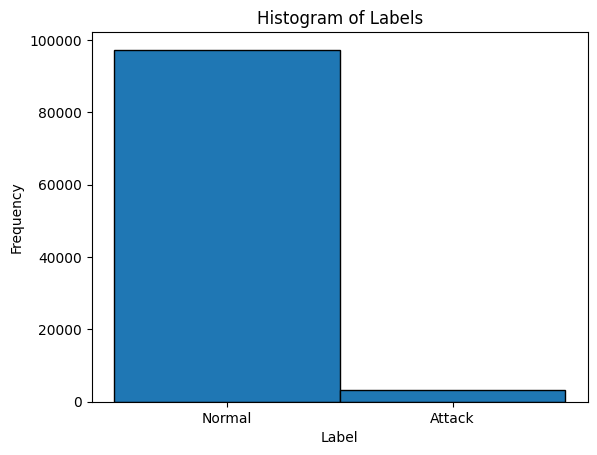

In [ ]:
# Plot label distribution
plt.hist(y, bins=[-0.5, 0.5, 1.5], edgecolor='black')
plt.xticks([0, 1], ['Normal', 'Attack'])
plt.title('Histogram of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

**Notes:**

- `fetch_kddcup99()` conveniently downloads and loads the dataset from scikit-learn’s built-in datasets.  
- Labels are converted from text (`b"normal."`, `b"attack"`) to integers (`0` and `1`).  
- The histogram provides a quick look at **class imbalance**, which is typical in cybersecurity data — attacks are rarer than normal events.  
- Using only 10% of the dataset keeps the demo lightweight while preserving statistical patterns.

## Unsupervised Learning with the KDDCUP99 Dataset
Unsupervised learning methods allow us to detect patterns and clusters in the network traffic dataset without using labels. In this section, we demonstrate **K-Means**, **DBSCAN**, and **Hierarchical Clustering** on PCA-reduced KDDCUP99 data.

### PCA (Principal Component Analysis)

PCA is a linear dimensionality reduction technique that finds new orthogonal axes (principal components) along which the variance of the data is maximized.  
> **Note:** It prioritizes directions where the data varies the most, since higher variance typically corresponds to more informative features.

In [ ]:
# Reduce dimensionality for visualization
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_processed)

**Notes:**
- PCA maximizes the variance captured in the reduced space.
- Principal components are **uncorrelated** (orthogonal).
- Often used for visualization, noise reduction, and improving clustering efficiency.

### K-Means Clustering

**Mathematical Idea:** <br>
K-Means partitions $n$ points $\{x_1, ..., x_n\}$ into $k$ clusters $C_1,...,C_k$ by minimizing:

$J = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2$

where $\mu_i$ is the centroid of cluster $C_i$.

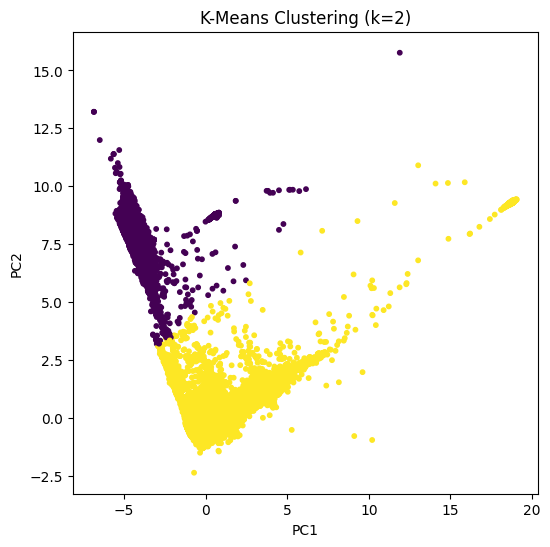

In [ ]:
# K-Means with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# Plot K-Means clusters
plt.figure(figsize=(6,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title("K-Means Clustering (k=2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Notes:

- **K-Means** partitions data into $k$ clusters based on similarity.
- Each point is assigned to the nearest cluster centroid.
- Requires specifying the number of clusters $k$ which is often done using the [Elbow Method](https://www.geeksforgeeks.org/machine-learning/elbow-method-for-optimal-value-of-k-in-kmeans/).


### DBSCAN – Density-Based Spatial Clustering

DBSCAN is a non-parametric clustering algorithm which clusters points based on density:
- A point is a **core point** if at least `min_samples` points are within `eps` distance.
- **Border points** are reachable from core points.
- **Noise points** are those not reachable from any core point.


In [ ]:
# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=25)
dbscan_labels = dbscan.fit_predict(X_pca)

# Plot DBSCAN clusters
plt.figure(figsize=(6,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='plasma', s=10)
plt.title("DBSCAN Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Notes:
- **DBSCAN** groups points based on density.
- Can detect outliers as points not belonging to any cluster (label = -1).
- Does not require specifying the number of clusters (non-parametric).


## Supervised Learning with the KDDCUP99 Dataset

In this section, we will demonstrate **classic supervised learning algorithms** that require labeled data, specifically **Logistic Regression** and **Naive Bayes**, to detect attacks in network traffic.

### Logistic Regression
Logistic Regression is a classic supervised learning algorithm used for **binary classification** tasks.

**Mathematical Idea:**

Logistic Regression models the probability that a given input belongs to a class using the logistic (sigmoid) function:

$P(y=1 \mid \mathbf{x}) = \sigma(\mathbf{w}^\top \mathbf{x} + b) = \frac{1}{1 + \exp(-(\mathbf{w}^\top \mathbf{x} + b))}$

where:
- $\mathbf{x}$ is the feature vector,
- $\mathbf{w}$ are the model weights,
- $b$ is the bias term,
- $\sigma(\cdot)$ is the sigmoid function mapping any real number to $[0,1]$.

The model is trained by minimizing the **binary cross-entropy loss**:

$\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log \hat{y}_i + (1-y_i) \log (1-\hat{y}_i) \right]$

where $\hat{y}_i = P(y=1 \mid \mathbf{x}_i)$ and $y_i \in \{0,1\}$.

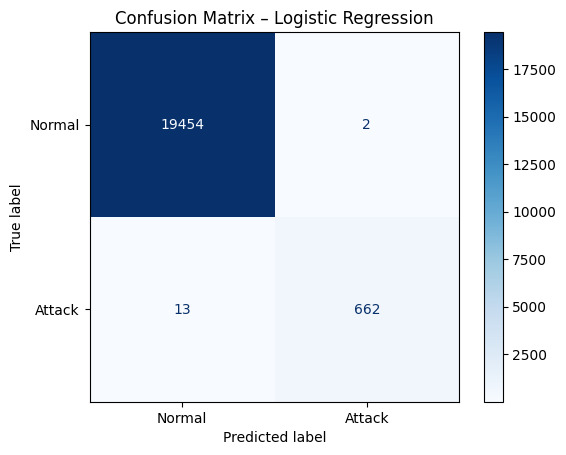

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     19456
      Attack       1.00      0.98      0.99       675

    accuracy                           1.00     20131
   macro avg       1.00      0.99      0.99     20131
weighted avg       1.00      1.00      1.00     20131



In [ ]:
# Train logistic regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Normal", "Attack"])
disp_lr.plot(cmap="Blues")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

# Classification report
print(classification_report(y_test, y_pred_lr, target_names=["Normal", "Attack"]))


Notes:

- Logistic Regression models the probability of class membership using a linear combination of features.
- Suitable for binary classification problems like normal vs attack detection.
- Standardizing features improves convergence and performance.


### Gaussian Naive Bayes

Gaussian Naive Bayes is a classic supervised learning algorithm based on **Bayes’ theorem** and the assumption that features are conditionally independent given the class label.  

**Mathematical Idea:**

For a feature vector $\mathbf{x} = [x_1, x_2, \dots, x_d]$ and a class $y \in \{0,1\}$, Gaussian Naive Bayes models the class conditional probability as:

$P(\mathbf{x} \mid y) = \prod_{j=1}^{d} P(x_j \mid y)$

Assuming each feature $x_j$ follows a Gaussian distribution for class $y$:

$P(x_j \mid y) = \frac{1}{\sqrt{2 \pi \sigma_{y,j}^2}}\exp\left(-\frac{(x_j - \mu_{y,j})^2}{2 \sigma_{y,j}^2}\right)$

where:
- $\mu_{y,j}$ is the mean of feature $x_j$ for class $y$,
- $\sigma_{y,j}^2$ is the variance of feature $x_j$ for class $y$.

The predicted class $\hat{y}$ is obtained using Bayes’ theorem:

$\hat{y} = \arg\max_y P(y) \prod_{j=1}^{d} P(x_j \mid y)$

Gaussian Naive Bayes is particularly fast and works well for high-dimensional numeric data.


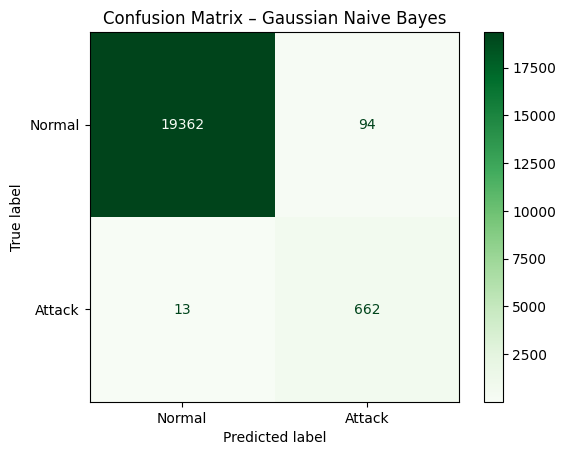

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     19456
      Attack       0.88      0.98      0.93       675

    accuracy                           0.99     20131
   macro avg       0.94      0.99      0.96     20131
weighted avg       1.00      0.99      0.99     20131



In [ ]:
# Train Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predictions
y_pred_gnb = gnb.predict(X_test)

# Confusion matrix
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
disp_gnb = ConfusionMatrixDisplay(confusion_matrix=cm_gnb, display_labels=["Normal", "Attack"])
disp_gnb.plot(cmap="Greens")
plt.title("Confusion Matrix – Gaussian Naive Bayes")
plt.show()

# Classification report
print(classification_report(y_test, y_pred_gnb, target_names=["Normal", "Attack"]))


Notes:

- Naive Bayes assumes feature independence given the class label.
- GaussianNB models numeric features as normally distributed.
- Fast to train and often performs well on high-dimensional datasets.


### Support Vector Machine (SVM)

Support Vector Machine (SVM) aims to find the optimal hyperplane that best separates the data into different classes.

**Mathematical Idea:**

Given a labeled dataset $(x_i, y_i)$, where $x_i \in \mathbb{R}^n$ and $y_i \in \{-1, +1\}$, the SVM optimization problem is formulated as:

$\min_{w, b} \ \frac{1}{2} \|w\|^2$

subject to:

$y_i (w \cdot x_i + b) \ge 1, \quad \forall i$

Here:
- $w$ is the weight vector perpendicular to the separating hyperplane.
- $b$ is the bias term that shifts the hyperplane.
- The decision boundary is given by $w \cdot x + b = 0$.

For non-linearly separable data, SVM uses the **kernel trick** to implicitly map input features into a higher-dimensional space where a linear separation becomes possible.

Common kernels include:
- **Linear kernel:** $K(x, x') = x \cdot x'$
- **Polynomial kernel:** $K(x, x') = (x \cdot x' + c)^d$
- **RBF (Gaussian) kernel:** $K(x, x') = \exp(-\gamma \|x - x'\|^2)$

The predicted class $\hat{y}$ for a test point $x$ is given by:

$\hat{y} = \text{sign}(w \cdot x + b)$

SVMs are robust to high-dimensional spaces and effective when the number of features exceeds the number of samples.


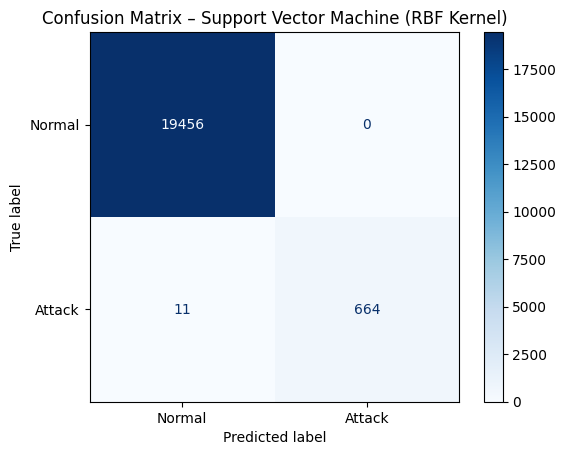

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     19456
      Attack       1.00      0.98      0.99       675

    accuracy                           1.00     20131
   macro avg       1.00      0.99      1.00     20131
weighted avg       1.00      1.00      1.00     20131



In [ ]:
# Train SVM with RBF kernel
svm_clf = SVC(kernel="rbf", C=1.0, gamma="scale")
svm_clf.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_clf.predict(X_test)

# Confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=["Normal", "Attack"])
disp_svm.plot(cmap="Blues")
plt.title("Confusion Matrix – Support Vector Machine (RBF Kernel)")
plt.show()

# Classification report
print(classification_report(y_test, y_pred_svm, target_names=["Normal", "Attack"]))


**Notes:**

- **SVMs** aim to **maximize the margin** between classes for better generalization.  
- The **RBF kernel** is often effective for **non-linear relationships**.  
- **Parameter tuning** (e.g., `C` and `gamma`) can significantly impact performance.  
- **SVMs** work well in **high-dimensional spaces**, but training can be **computationally intensive** on very large datasets.


## Exercises
In this exercise, we'll learn how to fit a Decision Tree classifier and how to evaluate the most important features in the KDD Cup 99 dataset.

### Exercise 1: Train Decision Tree Classifier
1. Train a `DecisionTreeClassifier` from `sklearn.tree` on the training data. You can find the technikal reference here: [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
2. Set `max_depth=10` for a manageable tree size.
3. Train the model with the allready imported and scaled data.
3. Evaluate on the test set using a confusion_matrix.

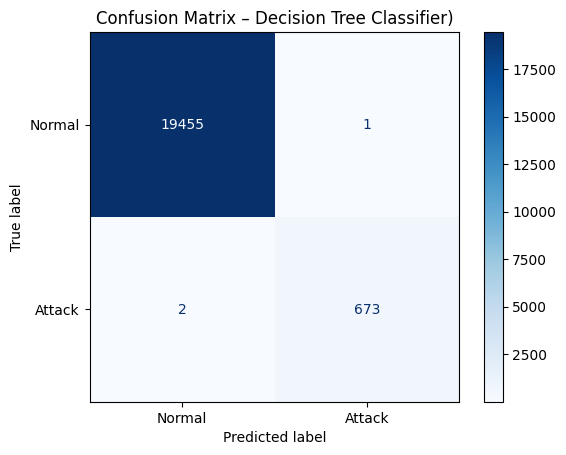

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     19456
      Attack       1.00      1.00      1.00       675

    accuracy                           1.00     20131
   macro avg       1.00      1.00      1.00     20131
weighted avg       1.00      1.00      1.00     20131



In [ ]:
# TODO: Step 1 - Train Decision Tree
# TODO: Step 2 - Predict test labels
# TODO: Step 3 - Print a confusion_matrix
from sklearn.tree import DecisionTreeClassifier

tree_classifier = DecisionTreeClassifier(max_depth=10, criterion='log_loss')
tree_classifier.fit(X_train, y_train)

y_pred_tc = tree_classifier.predict(X_test)

cm_tc = confusion_matrix(y_test, y_pred_tc)
disp_tc = ConfusionMatrixDisplay(confusion_matrix=cm_tc, display_labels=["Normal", "Attack"])
disp_tc.plot(cmap="Blues")
plt.title("Confusion Matrix – Decision Tree Classifier)")
plt.show()

# Classification report
print(classification_report(y_test, y_pred_tc, target_names=["Normal", "Attack"]))


### Exercise 2: Visualize the Decision Tree
1. Use `plot_tree` from `sklearn.tree` to visualize the tree. You can find the reference here: [plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)
2. Limit depth to 3 for better readability.
3. Include feature names and class names.

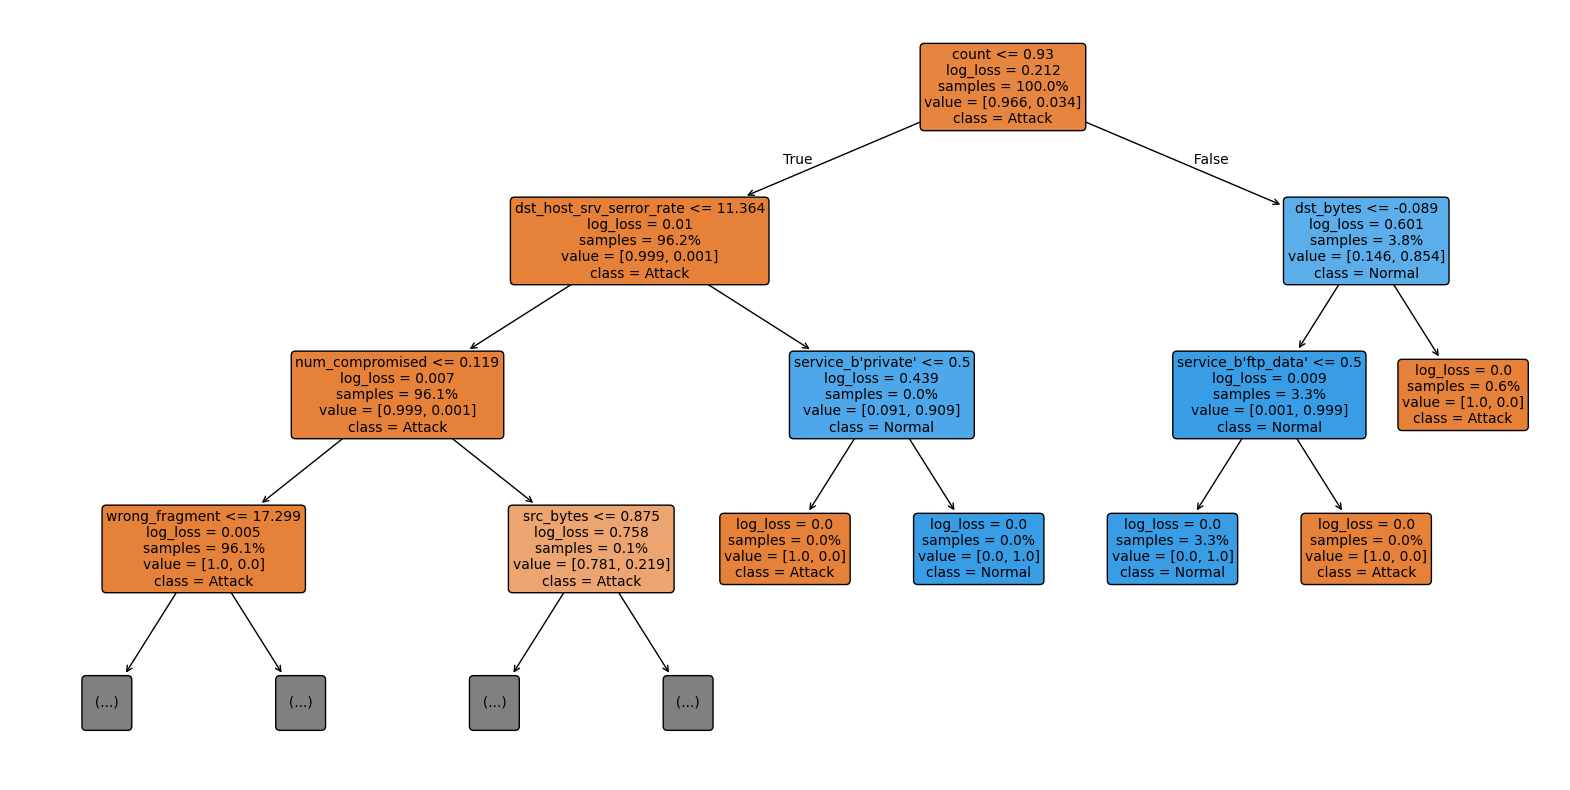

In [ ]:
# TODO: Step 1 - Visualize Decision Tree
# TODO: Step 2 - Configure plot_tree
# TODO: Step 3 - Show the plot

from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))

plot_tree(tree_classifier, max_depth=3, feature_names=list(numeric_features) + list(encoder.get_feature_names_out(categorical_features)), class_names=["Attack", "Normal"], filled=True, rounded=True, proportion=True, fontsize=10)

plt.show()


### Exercise 3: Feature Importance
1. Extract feature importances from the `feature_importances_` atttribut in the trained Decision Tree.
2. Plot the **top 10** features in a bar chart.
3. Interpret which features are most indicative of attacks and why.

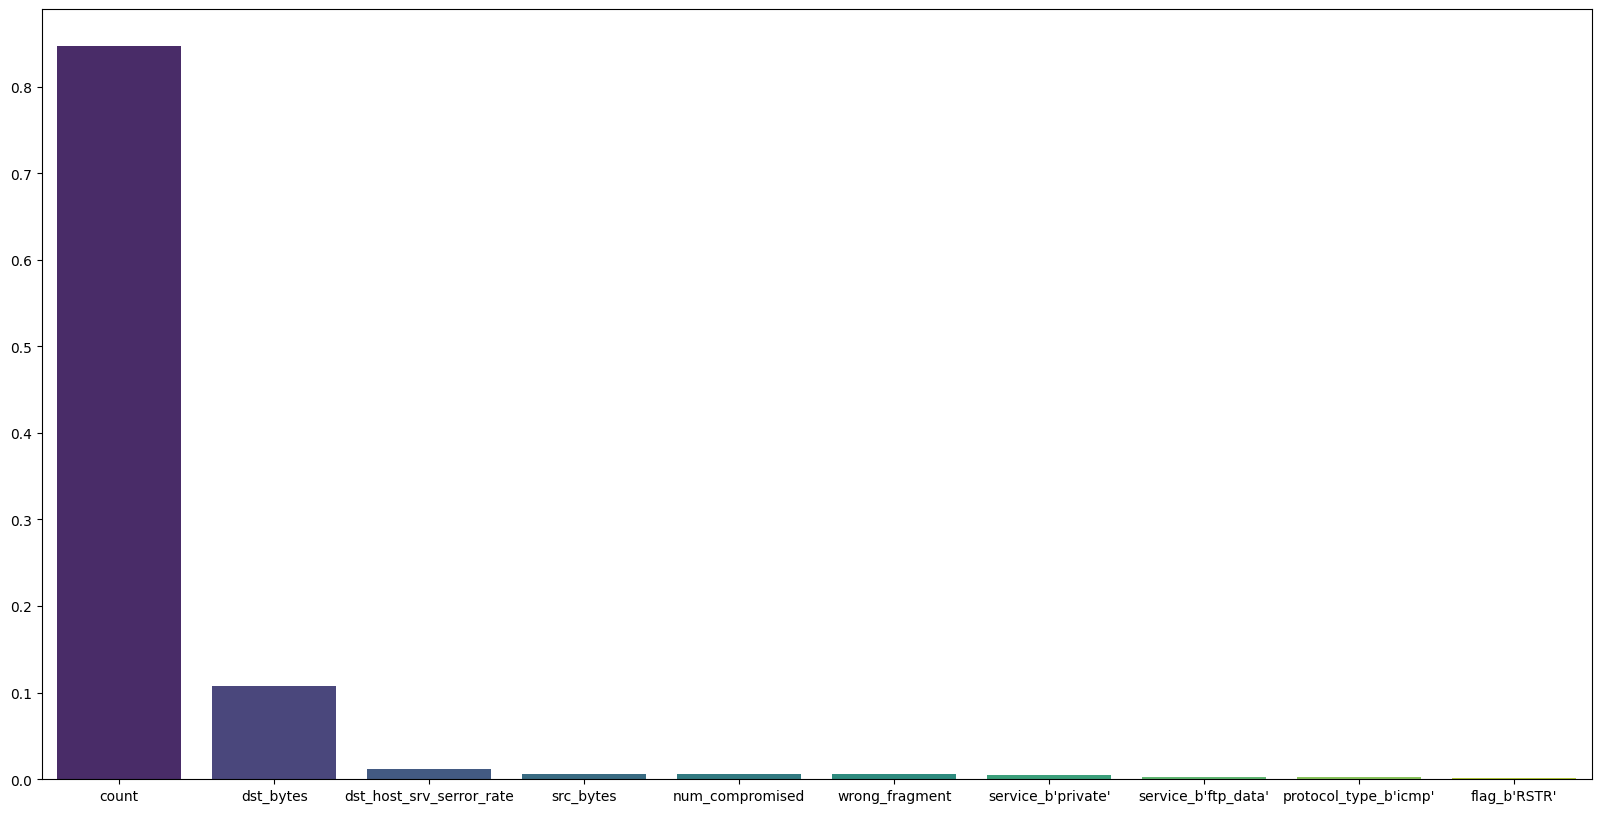

In [ ]:
# TODO: Step 1 - Get feature importances
# TODO: Step 2 - Plot top 10 features
# TODO: Step 3 - Interpret results
import seaborn as sns

plt.figure(figsize=(20,10))

importances = tree_classifier.feature_importances_
indices = np.argsort(tree_classifier.feature_importances_)[::-1][:10]
features = list(numeric_features) + list(encoder.get_feature_names_out(categorical_features))

sns.barplot(y=importances[indices], x=np.array(features)[indices], hue=np.array(features)[indices], palette="viridis", legend=False)
plt.show()


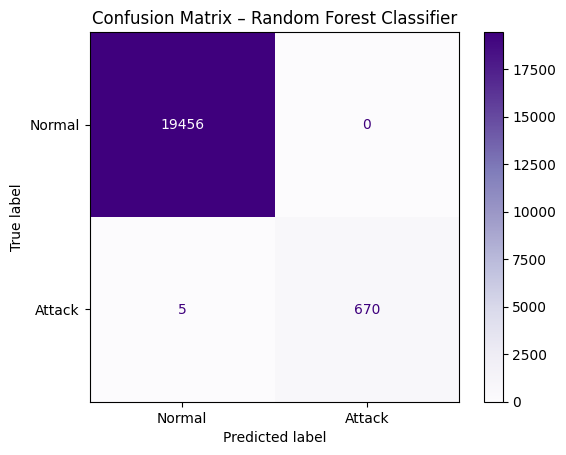

In [ ]:
# step 1: implement Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, criterion="log_loss")
rf_clf.fit(X_train, y_train)
# step 2 : predict test labels
y_pred_rf = rf_clf.predict(X_test)
#step 3: print confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Normal", "Attack"])
disp_rf.plot(cmap="Purples")
plt.title("Confusion Matrix – Random Forest Classifier")
plt.show()

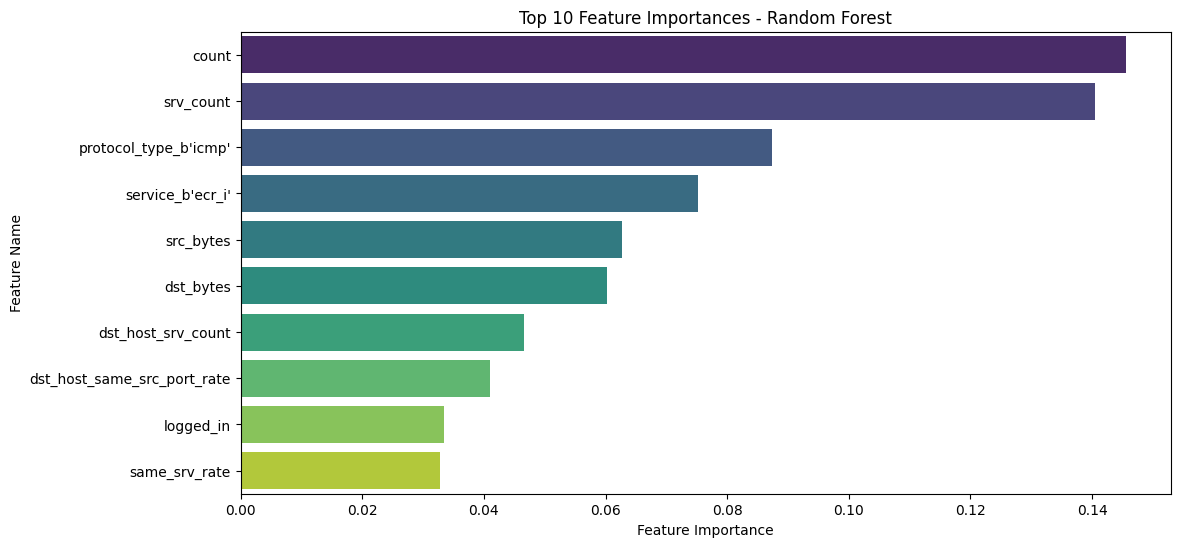

In [ ]:
# Step 1 - Get feature importances
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = list(numeric_features) + list(encoder.get_feature_names_out(categorical_features))

# Step 2 - Select top 10 features
n_top_features = 10
top_n_features = np.array(feature_names)[indices][:n_top_features]
top_n_importances = importances[indices][:n_top_features]

# Step 3 - Plot top 10 feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=top_n_importances, y=top_n_features, hue=top_n_features, palette="viridis")
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.show()

### Exercise 4: Parameter Optimization for SVM

In the SVM example above, we initially guessed the hyperparameters `C`, `gamma`, and `kernel` based on experience. In this exercise, we'll try to find better parameters using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), which performs cross-validated grid-search over a parameter grid using the estimator's `fit` and `score` methods.

1. Familiarize yourself with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) on the scikit-learn documentation.  
2. Use the provided **SVM** model and perform a **GridSearchCV** to tune hyperparameters `C`, `gamma`, and `kernel`.  
3. Identify and print the **best parameter combination** and **cross-validation accuracy** from the grid search.  
4. Re-train the SVM using these optimal parameters and evaluate it on the **test dataset**.  
5. Compare the performance (e.g., accuracy, precision, recall) of the optimized model to the default SVM.  
6. Discuss how parameter tuning affects the **margin width**, **model capacity**, and **generalization** ability of SVMs.


In [ ]:
# TODO: Step 0 - Import necessary libraries
from sklearn.model_selection import GridSearchCV


In [ ]:
# TODO: Step 1 - Define the parameter grid for SVM
parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'C':[0.1, 10], 'gamma': ['scale', 'auto']}



In [ ]:
# TODO: Step 2 - Initialize the SVM classifier
svm_search = SVC()


In [ ]:
# TODO: Step 3 - Create a GridSearchCV object with 5-fold cross-validation
gridsearch = GridSearchCV(svm_search, parameters, cv = 5, verbose = 0, n_jobs=-1, scoring='balanced_accuracy')



In [ ]:
# TODO: Step 4 - Fit the GridSearchCV on the training data
gridsearch.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='balanced_accuracy')

In [ ]:
# TODO: Step 5 - Print the best parameters and best cross-validation score
print(gridsearch.best_params_)
print(gridsearch.best_score_)


{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.9984877635458043


In [ ]:
# TODO: Step 6 - Retrieve the best model and make predictions on the test set
best_svm = gridsearch.best_estimator_
best_svm_predictions = best_svm.predict(X_test)



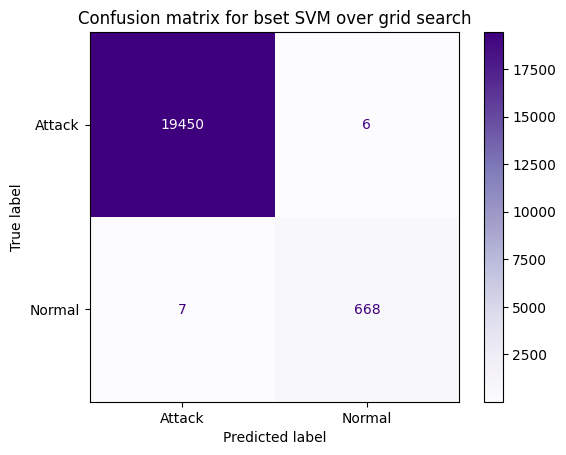

In [ ]:
# TODO: Step 7 - Plot the confusion matrix for the best SVM model
cm_best_svm = confusion_matrix(y_test, best_svm_predictions)
disp_best_svm = ConfusionMatrixDisplay(confusion_matrix=cm_best_svm, display_labels=["Attack", "Normal"])
disp_best_svm.plot(cmap="Purples")
plt.title("Confusion matrix for bset SVM over grid search")
plt.show()

In [ ]:
# TODO: Step 8 - Print the classification report
print(classification_report(y_test, best_svm_predictions, target_names=["Normal", "Attack"]))

print(classification_report(y_test, y_pred_svm, target_names=["Normal", "Attack"]))


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     19456
      Attack       0.99      0.99      0.99       675

    accuracy                           1.00     20131
   macro avg       1.00      0.99      1.00     20131
weighted avg       1.00      1.00      1.00     20131

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     19456
      Attack       1.00      0.98      0.99       675

    accuracy                           1.00     20131
   macro avg       1.00      0.99      1.00     20131
weighted avg       1.00      1.00      1.00     20131



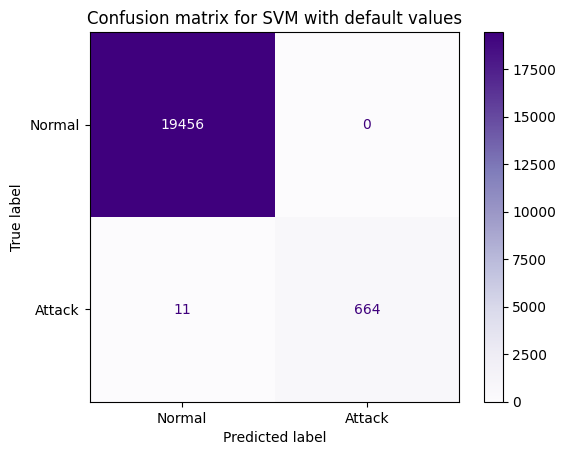

In [ ]:
disp_svm.plot(cmap="Purples")
plt.title("Confusion matrix for SVM with default values")
plt.show()

In [ ]:
# TODO: Step 9 - Interpret results
# - Compare default vs optimized model performance.
# - Discuss how tuning C, gamma, and kernel affected accuracy and generalization.

Looking at the classification reports for both the default SVM and the optimized SVM:

Default SVM: Achieved excellent performance with high precision, recall, and f1-score for both "Normal" and "Attack" classes. Specifically, it had a perfect precision for both classes and a recall of 0.98 for the "Attack" class.
Optimized SVM: Also achieved very high performance, similar to the default model. It had a slightly lower precision for the "Attack" class (0.99 compared to 1.00) but a slightly higher recall (0.99 compared to 0.98), resulting in a slightly higher f1-score for the "Attack" class (0.99 compared to 0.99). The overall accuracy remained very high for both models.
In this particular dataset and with this split, both the default parameters and the optimized parameters yielded very similar and high-performing models. The slight differences in precision and recall for the "Attack" class suggest a trade-off that the optimized parameters found, which might be slightly more balanced in identifying attacks.

Discussion on the Effect of Tuning C, Gamma, and Kernel:

Kernel: The kernel function determines the type of hyperplane used to separate the data.
linear: Creates a linear decision boundary.
poly: Creates a polynomial decision boundary.
rbf (Radial Basis Function): Creates a non-linear decision boundary that can capture complex relationships.
sigmoid: Creates a non-linear decision boundary based on the sigmoid function. The grid search found that the poly kernel with the optimized parameters performed best in terms of balanced accuracy during cross-validation. This suggests that a polynomial boundary was slightly better at separating the classes in the feature space compared to the linear or RBF kernels for the given data and parameter range.
C (Regularization Parameter): The C parameter controls the trade-off between achieving a low training error and a large margin.
A small C creates a wider margin but allows more misclassifications (higher bias, lower variance).
A large C creates a narrower margin but allows fewer misclassifications (lower bias, higher variance). The grid search found that C=10 was part of the best parameter combination. This indicates that a relatively smaller margin (allowing fewer misclassifications on the training data) was beneficial for this dataset.
gamma (Kernel Coefficient for RBF, poly and sigmoid): The gamma parameter defines how much influence a single training example has.
A small gamma means a large influence, resulting in a smoother decision boundary (lower variance, higher bias).
A large gamma means a small influence, resulting in a more complex, potentially wiggly decision boundary (higher variance, lower bias). The grid search found that gamma='auto' was part of the best parameter combination. When gamma='auto', the value is set to 1 / n_features. This suggests that using a gamma value scaled by the number of features was effective in finding a good balance between bias and variance for the chosen kernel.
Impact on Margin Width, Model Capacity, and Generalization:

Margin Width: The C parameter directly influences the margin width. A larger C (like 10 in the optimized model) generally leads to a smaller margin, focusing on correctly classifying training points even if it means a less robust separation for unseen data.
Model Capacity: The kernel and gamma parameters affect the model's capacity to fit the training data. Non-linear kernels (poly, rbf, sigmoid) and larger gamma values increase the model's capacity, allowing it to learn more complex patterns. The poly kernel chosen by the grid search suggests that some non-linearity in the decision boundary was beneficial.
Generalization: The goal of parameter tuning is to improve generalization, which is the model's ability to perform well on unseen data. While both models performed very well on the test set in this case, the grid search process helps to find parameters that are likely to generalize better to new data by evaluating performance on multiple cross-validation folds. The slightly improved recall for the "Attack" class in the optimized model might indicate slightly better generalization in identifying positive cases.
In summary, while the default SVM already performed exceptionally well on this dataset, the grid search identified parameters that slightly improved the balanced accuracy during cross-validation, potentially leading to a more robust model for detecting attacks. The best parameters suggest that a polynomial kernel with a moderate C value and an automatically scaled gamma were optimal for this specific task and dataset.

<span style="color:green">

## Solution - Exercise 1: Train Decision Tree Classifier

We train a `DecisionTreeClassifier` from `sklearn.tree` on the training data (see the technical reference [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)) and set `max_depth=10` for a manageable tree size, using the already imported and scaled data.  
After training, we evaluate the model on the test set using a confusion matrix to assess its performance.

</span>

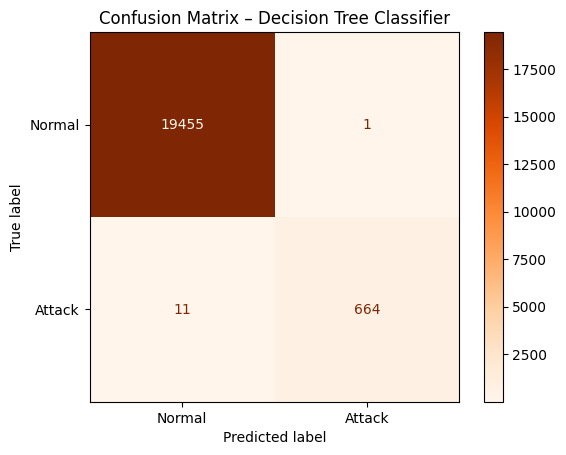

In [ ]:
# TODO: Step 1 - Train Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_clf.fit(X_train, y_train)

# TODO: Step 2 - Predict test labels
y_pred = dt_clf.predict(X_test)

# TODO: Step 3 - Print a confusion_matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Attack"])
disp.plot(cmap="Oranges")
plt.title("Confusion Matrix – Decision Tree Classifier")
plt.show()

<span style="color:green">

## Solution - Exercise 2: Visualize the Decision Tree
We use `plot_tree` from `sklearn.tree` to visualize the decision tree (see the reference [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)) and limit the depth to 3 for better readability.  
Additionally, we include feature names and class names in the plot to make it easier to interpret.


</span>

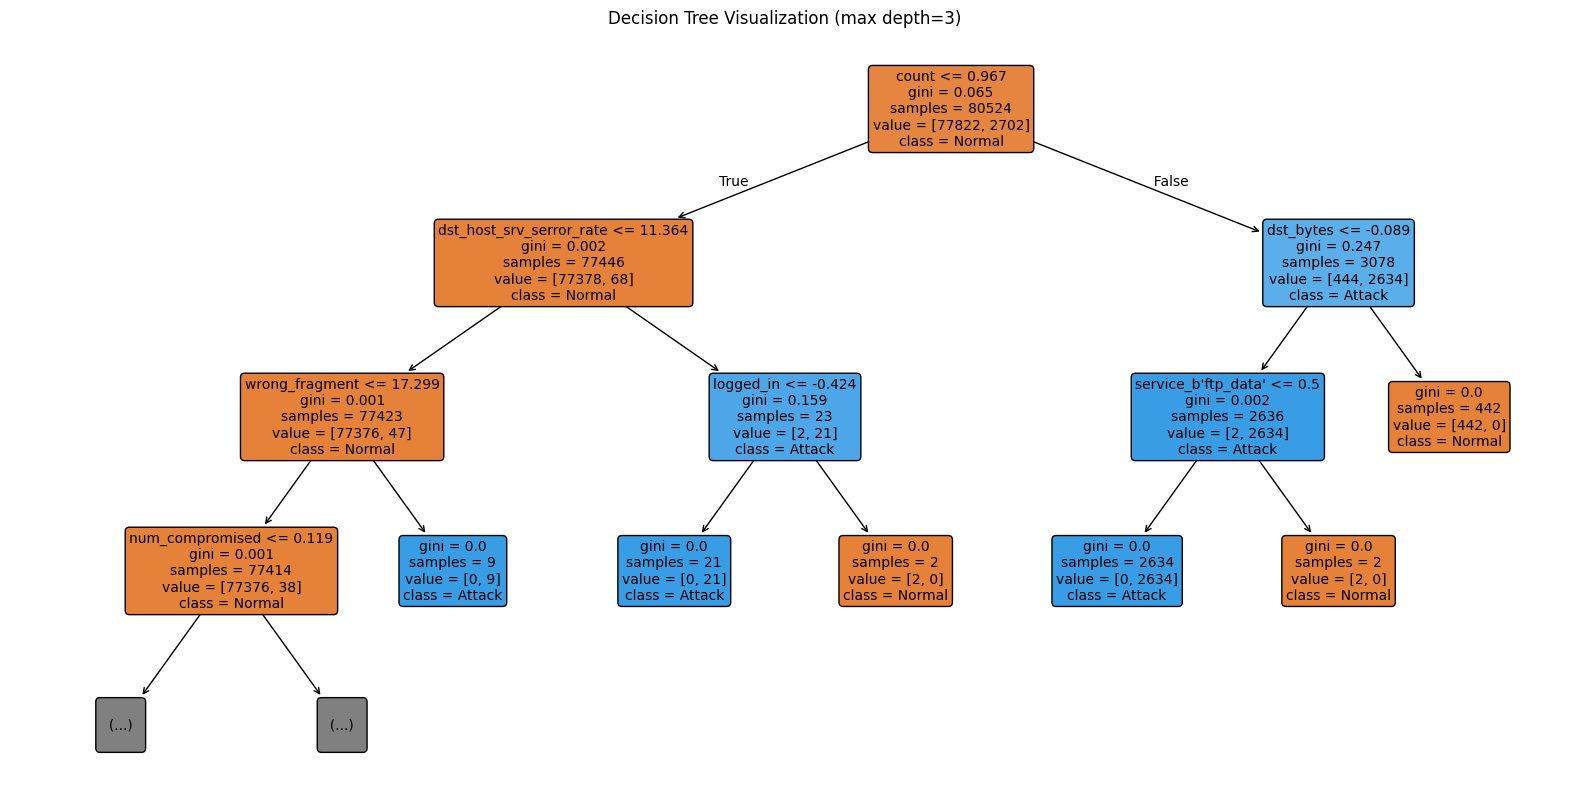

In [ ]:
# TODO: Step 1 - Visualize Decision Tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))

# TODO: Step 2 - Configure plot_tree
plot_tree(dt_clf, max_depth=3, feature_names=list(numeric_features) + list(encoder.get_feature_names_out(categorical_features)),
          class_names=["Normal", "Attack"], filled=True, rounded=True, fontsize=10)

# TODO: Step 3 - Show the plot
plt.title("Decision Tree Visualization (max depth=3)")
plt.show()

<span style="color:green">

## Solution - Exercise 3: Feature Importance
We extract feature importances from the `feature_importances_` attribute of the trained Decision Tree and plot the top 10 features in a bar chart.  
Finally, we interpret which features are most indicative of attacks and explain why they are important.

</span>

/var/folders/zm/0r1v0fg50w53tw219k1jp0ym0000gn/T/ipykernel_39233/4014255988.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n_importances, y=top_n_features, palette="viridis")


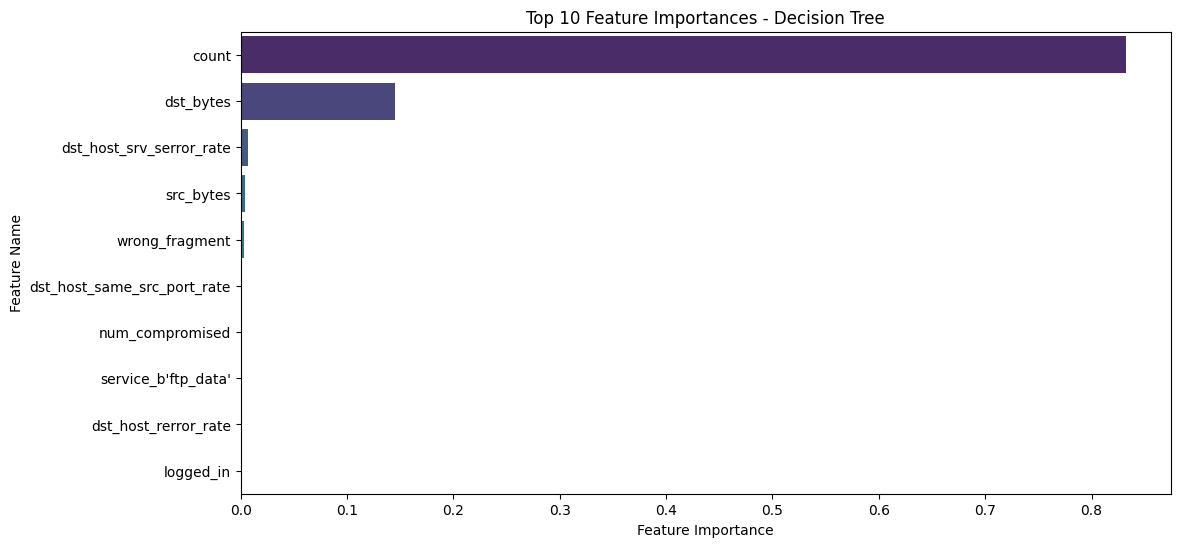

In [ ]:
import seaborn as sns
# TODO: Step 1 - Get feature importances
importances = dt_clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = list(numeric_features) + list(encoder.get_feature_names_out(categorical_features))
# TODO: Step 2 - Plot top 10 features
n_top_features = 10
top_n_features = np.array(feature_names)[indices][:n_top_features]
top_n_importances = importances[indices][:n_top_features]

# TODO: Step 3 - Interpret results
plt.figure(figsize=(12, 6))
sns.barplot(x=top_n_importances, y=top_n_features, palette="viridis")
plt.title("Top 10 Feature Importances - Decision Tree")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.show()

<span style="color:green">

**Note:**  
The `count` feature is by far the most important, and the entire classification relies heavily on it. This can pose a problem for the robustness of the classifier if it depends primarily on a single feature. The `count` feature represents the number of connections to the same host as the current connection in the past two seconds.

Using a Random Forest can make the model more robust because it combines the predictions of multiple decision trees, each trained on a random subset of the data and features.  
This reduces the reliance on a single feature like `count`, mitigates overfitting, and generally improves the stability and generalization of the classifier.


</span>


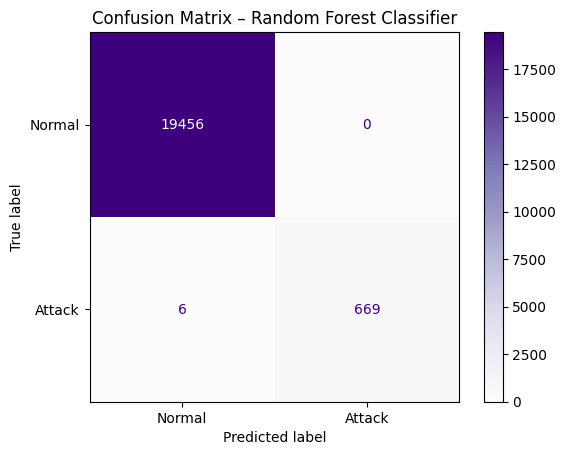

In [ ]:
# step 1: implement Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_clf.fit(X_train, y_train)
# step 2 : predict test labels
y_pred_rf = rf_clf.predict(X_test)
#step 3: print confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Normal", "Attack"])
disp_rf.plot(cmap="Purples")
plt.title("Confusion Matrix – Random Forest Classifier")
plt.show()

/var/folders/zm/0r1v0fg50w53tw219k1jp0ym0000gn/T/ipykernel_39233/3226767616.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n_importances, y=top_n_features, palette="viridis")


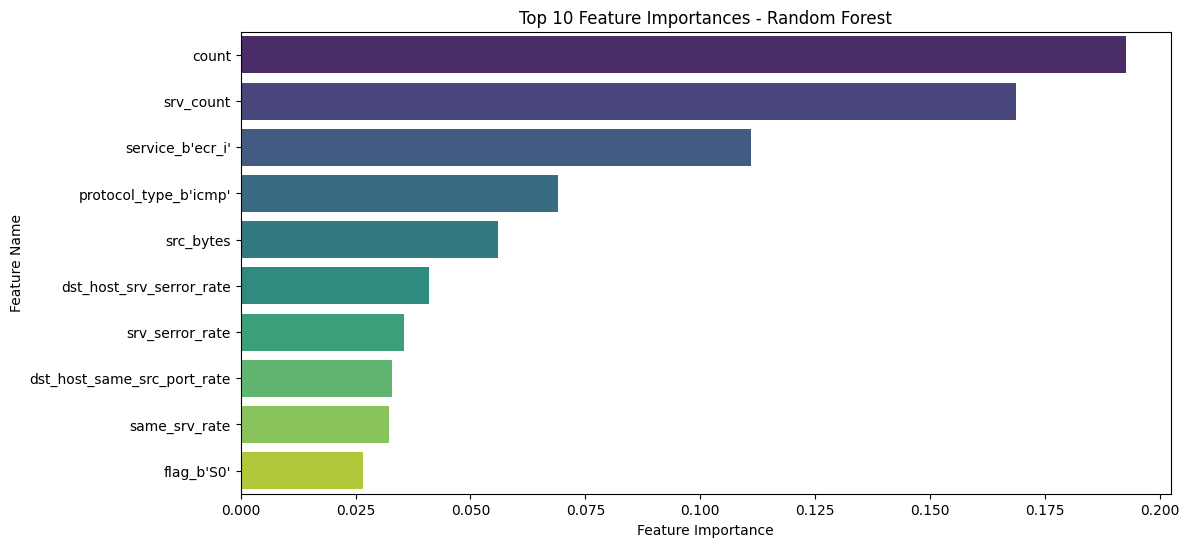

In [ ]:
# Step 1 - Get feature importances
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = list(numeric_features) + list(encoder.get_feature_names_out(categorical_features))

# Step 2 - Select top 10 features
n_top_features = 10
top_n_features = np.array(feature_names)[indices][:n_top_features]
top_n_importances = importances[indices][:n_top_features]

# Step 3 - Plot top 10 feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=top_n_importances, y=top_n_features, palette="viridis")
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.show()

<span style="color:green">

## Solution - Exercise 4: Parameter Optimization for SVM

In the previous SVM example, we initially selected hyperparameters `C`, `gamma`, and `kernel` based on experience.  
In this exercise, we use `GridSearchCV` to systematically search for the best hyperparameter combination, re-train the SVM with these optimal values, and evaluate its performance on the test dataset to analyze the effect on margin width, model capacity, and generalization.


</span>

Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9979521670185185


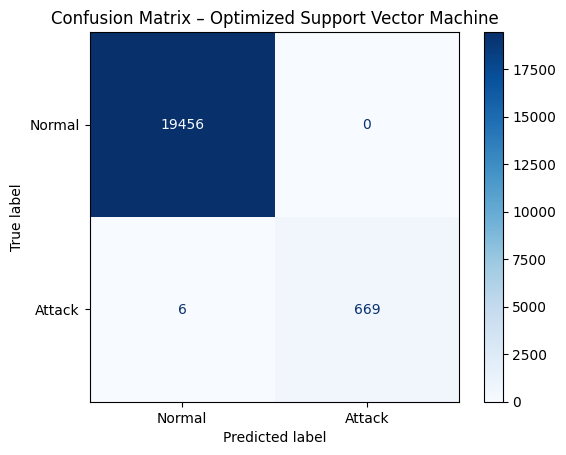

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19456
           1       1.00      0.99      1.00       675

    accuracy                           1.00     20131
   macro avg       1.00      1.00      1.00     20131
weighted avg       1.00      1.00      1.00     20131



In [ ]:
# TODO: Step 0 - Import necessary libraries
from sklearn.model_selection import GridSearchCV

# TODO: Step 1 - Define the parameter grid for SVM
# populate grid for better coverage of parameter space
param_grid = {
    'C': [0.1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

# TODO: Step 2 - Initialize the SVM classifier
svm_clf = SVC()

# TODO: Step 3 - Create a GridSearchCV object with 5-fold cross-validation
# for debugging and understanding set verbose=2, for the rendering to html it was set to 0
grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid,
                           scoring='balanced_accuracy', cv=5, n_jobs=-1, verbose=0) # Use balanced_accuracy for imbalanced data

# TODO: Step 4 - Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# TODO: Step 5 - Print the best parameters and best cross-validation score
print("Best Parameters:", grid_search.best_params_)
print("Best balanced_accuracy Score:", grid_search.best_score_)

# TODO: Step 6 - Retrieve the best model and make predictions on the test set
best_svm_clf = grid_search.best_estimator_
y_pred_svm = best_svm_clf.predict(X_test)

# TODO: Step 7 - Plot the confusion matrix for the best SVM model
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=["Normal", "Attack"])
disp_svm.plot(cmap="Blues")
plt.title("Confusion Matrix – Optimized Support Vector Machine")
plt.show()

# TODO: Step 8 - Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

# TODO: Step 9 - Interpret results
# - Compare default vs optimized model performance.
# - Discuss how tuning C, gamma, and kernel affected accuracy and generalization.


## Conclusion
In this tutorial, we applied classic machine learning techniques using scikit-learn to cybersecurity tasks, such as detecting network attacks. By preprocessing data, encoding features, and training models, we gained insights into how to **effectively classify normal and malicious traffic** and how to **identify patterns in network data** to provide actionable insights for cybersecurity.

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/clandolt/mlcysec_notebooks/)  If you found this tutorial helpful, please **⭐ star our repository** to show your support.   
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/clandolt/mlcysec_notebooks/issues)  For any **questions**, **typos**, or **bugs**, kindly open an issue on GitHub — we appreciate your feedback!

---